In [1]:
!nvidia-smi

Thu Jun  6 22:50:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:01:00.0 Off |                  Off |
| 30%   34C    P3              55W / 300W |      1MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import json

from unsloth import FastLanguageModel, PatchDPOTrainer
#from unsloth import is_bfloat16_supported
PatchDPOTrainer()
import torch
from transformers import TrainingArguments, AutoTokenizer
from trl import DPOTrainer

from datasets import Dataset

In [3]:
BASE_MODEL_FP = "/root/text-generation-webui/models/unsloth_llama-3-70b-Instruct-bnb-4bit/"
TRAIN_DATA_FP = 'data/llama3-instruct_train_dpo.json'
QLORA_FP = '/root/text-generation-webui/loras/37outof50_with_2_errors'

In [4]:
max_seq_length = 1024+256

In [5]:
train_dataset = Dataset.from_json(TRAIN_DATA_FP)

In [6]:
model, tokenizer = FastLanguageModel.from_pretrained(model_name=QLORA_FP, use_gradient_checkpointing = "unsloth")

==((====))==  Unsloth: Fast Llama patching release 2024.4
   \\   /|    GPU: NVIDIA RTX 6000 Ada Generation. Max memory: 47.507 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/root/text-generation-webui/models/unsloth_llama-3-70b-Instruct-bnb-4bit/ does not have a padding token! Will use pad_token = <|reserved_special_token_250|>.
Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2024.4 patched 80 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [7]:
# from peft import PeftModel


# model = FastLanguageModel.get_peft_model(
#     base_model,
#     r = 32,
#     target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
#                       "gate_proj", "up_proj", "down_proj",],
#     lora_alpha = 32,
#     lora_dropout = 0, # Dropout = 0 is currently optimized
#     bias = "none",    # Bias = "none" is currently optimized
#     use_gradient_checkpointing = True,
#     random_state = 3407,
# )

In [8]:
model.load_adapter(QLORA_FP, adapter_name='reference')

_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight', 'base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.weight', 'base_model.model.model.layers.0.mlp.gate_proj.weight', 'base_model.model.model.layers.0.mlp.up_proj.weight', 'base_model.model.model.layers.0.mlp.down_proj.weight', 'base_model.model.model.layers.0.input_layernorm.weight', 'base_model.model.model.layers.0.post_attention_layernorm.weight', 'base_model.model.model.layers.1.self_attn.q_proj.base_layer.weight', 'base_m

In [9]:
model.active_adapters

['default']

In [10]:
# Load the adapter a second time, with a different name, which will be our reference model.
#model.load_adapter(QLORA_FP, adapter_name="reference");

(array([ 19., 134., 452., 569., 423., 280., 255., 111.,  34.,  15.]),
 array([ 525. ,  589.2,  653.4,  717.6,  781.8,  846. ,  910.2,  974.4,
        1038.6, 1102.8, 1167. ]),
 <BarContainer object of 10 artists>)

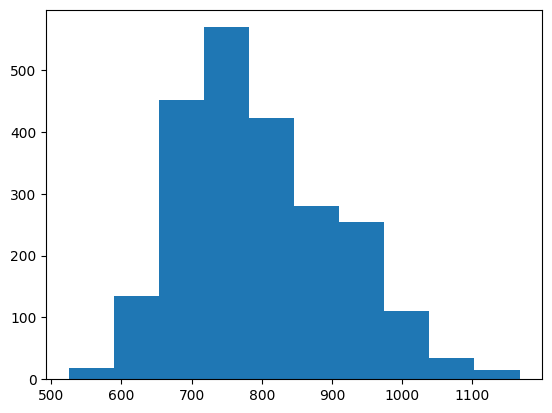

In [11]:
import matplotlib.pyplot as plt
plt.hist([len(tokenizer.encode(x['prompt']))+max(len(tokenizer.encode(x['rejected'])), len(tokenizer.encode(x['chosen']))) for x in train_dataset])

(array([ 72., 498., 816., 450., 233., 174.,  34.,   0.,   0.,  15.]),
 array([436. , 457.9, 479.8, 501.7, 523.6, 545.5, 567.4, 589.3, 611.2,
        633.1, 655. ]),
 <BarContainer object of 10 artists>)

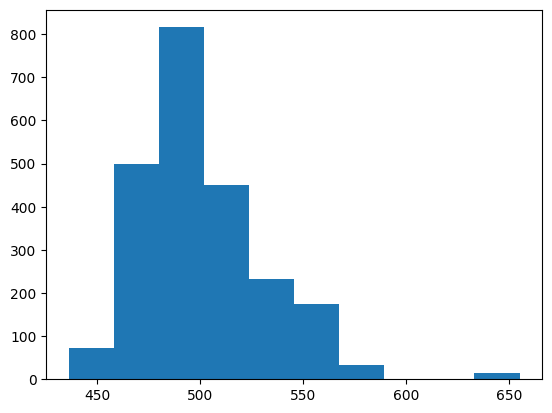

In [12]:
plt.hist([len(tokenizer.encode(x['prompt'])) for x in train_dataset])

In [ ]:
dpo_trainer = DPOTrainer(
    model = model,
    #ref_model = None,
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,
        warmup_steps = 10,
        learning_rate=2e-05,
        num_train_epochs = 3,
        fp16 = False,
        bf16 = True,
        logging_steps = 1,
        #optim = "adamw_8bit",
        optim = 'adafactor',
        seed = 42,
        output_dir = "outputs",
    ),
    beta = 0.1,
    train_dataset = train_dataset,
    # eval_dataset = YOUR_DATASET_HERE,
    tokenizer = tokenizer,
    max_length = 1024,
    max_prompt_length = 550,
    model_adapter_name="default",
    ref_adapter_name="reference"
)
dpo_trainer.train()

/opt/conda/lib/python3.10/site-packages/trl/trainer/dpo_trainer.py:332: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,292 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 8
\        /    Total batch size = 8 | Total steps = 858
 "-____-"     Number of trainable parameters = 262,144,000
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen
1,0.693100,0.000000,0.000000,0.000000,0.000000,-27.142984,-26.198196,0.211682,0.209226
2,0.693100,0.000000,0.000000,0.000000,0.000000,-29.517939,-26.686356,0.236194,0.242418
3,0.686300,0.005166,-0.008891,0.625000,0.014057,-33.295029,-24.746006,0.183436,0.172751
4,0.686000,0.007480,-0.007116,0.750000,0.014595,-27.891937,-15.872861,0.215611,0.224054
5,0.635300,0.016590,-0.113025,0.875000,0.129615,-31.094555,-21.981188,0.231036,0.232821
6,0.723800,-0.116079,-0.066079,0.375000,-0.050000,-28.000820,-36.585037,0.196637,0.194673
7,0.679200,-0.022360,-0.052115,0.500000,0.029755,-31.201651,-24.451223,0.222151,0.224939
8,0.691800,-0.028498,-0.034903,0.375000,0.006405,-27.214504,-16.304646,0.189833,0.188696
9,0.624200,-0.039975,-0.209909,0.500000,0.169934,-29.671440,-14.655938,0.234351,0.232474
10,0.636100,-0.076314,-0.224592,0.500000,0.148278,-23.686352,-23.105507,0.236654,0.237471


In [ ]:
6*7*198213